In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import layers
import seaborn as sns

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

In [181]:
USE_BT = True


DATASET_ROOT="data/"
TRAIN_LOCATIONS_FILE="SignatureLocs.csv"
TEST_LOCATIONS_FILE="TestLocs.csv"
TRAIN_STRENGTHS_FILE="P_Signatures.csv" if USE_BT else "P_SA_Signatures.csv"
TEST_STRENGTHS_FILE="P_Tests.csv" if USE_BT else "P_SA_Tests.csv"
NUMBER_OF_BEACONS=57 if USE_BT else 11

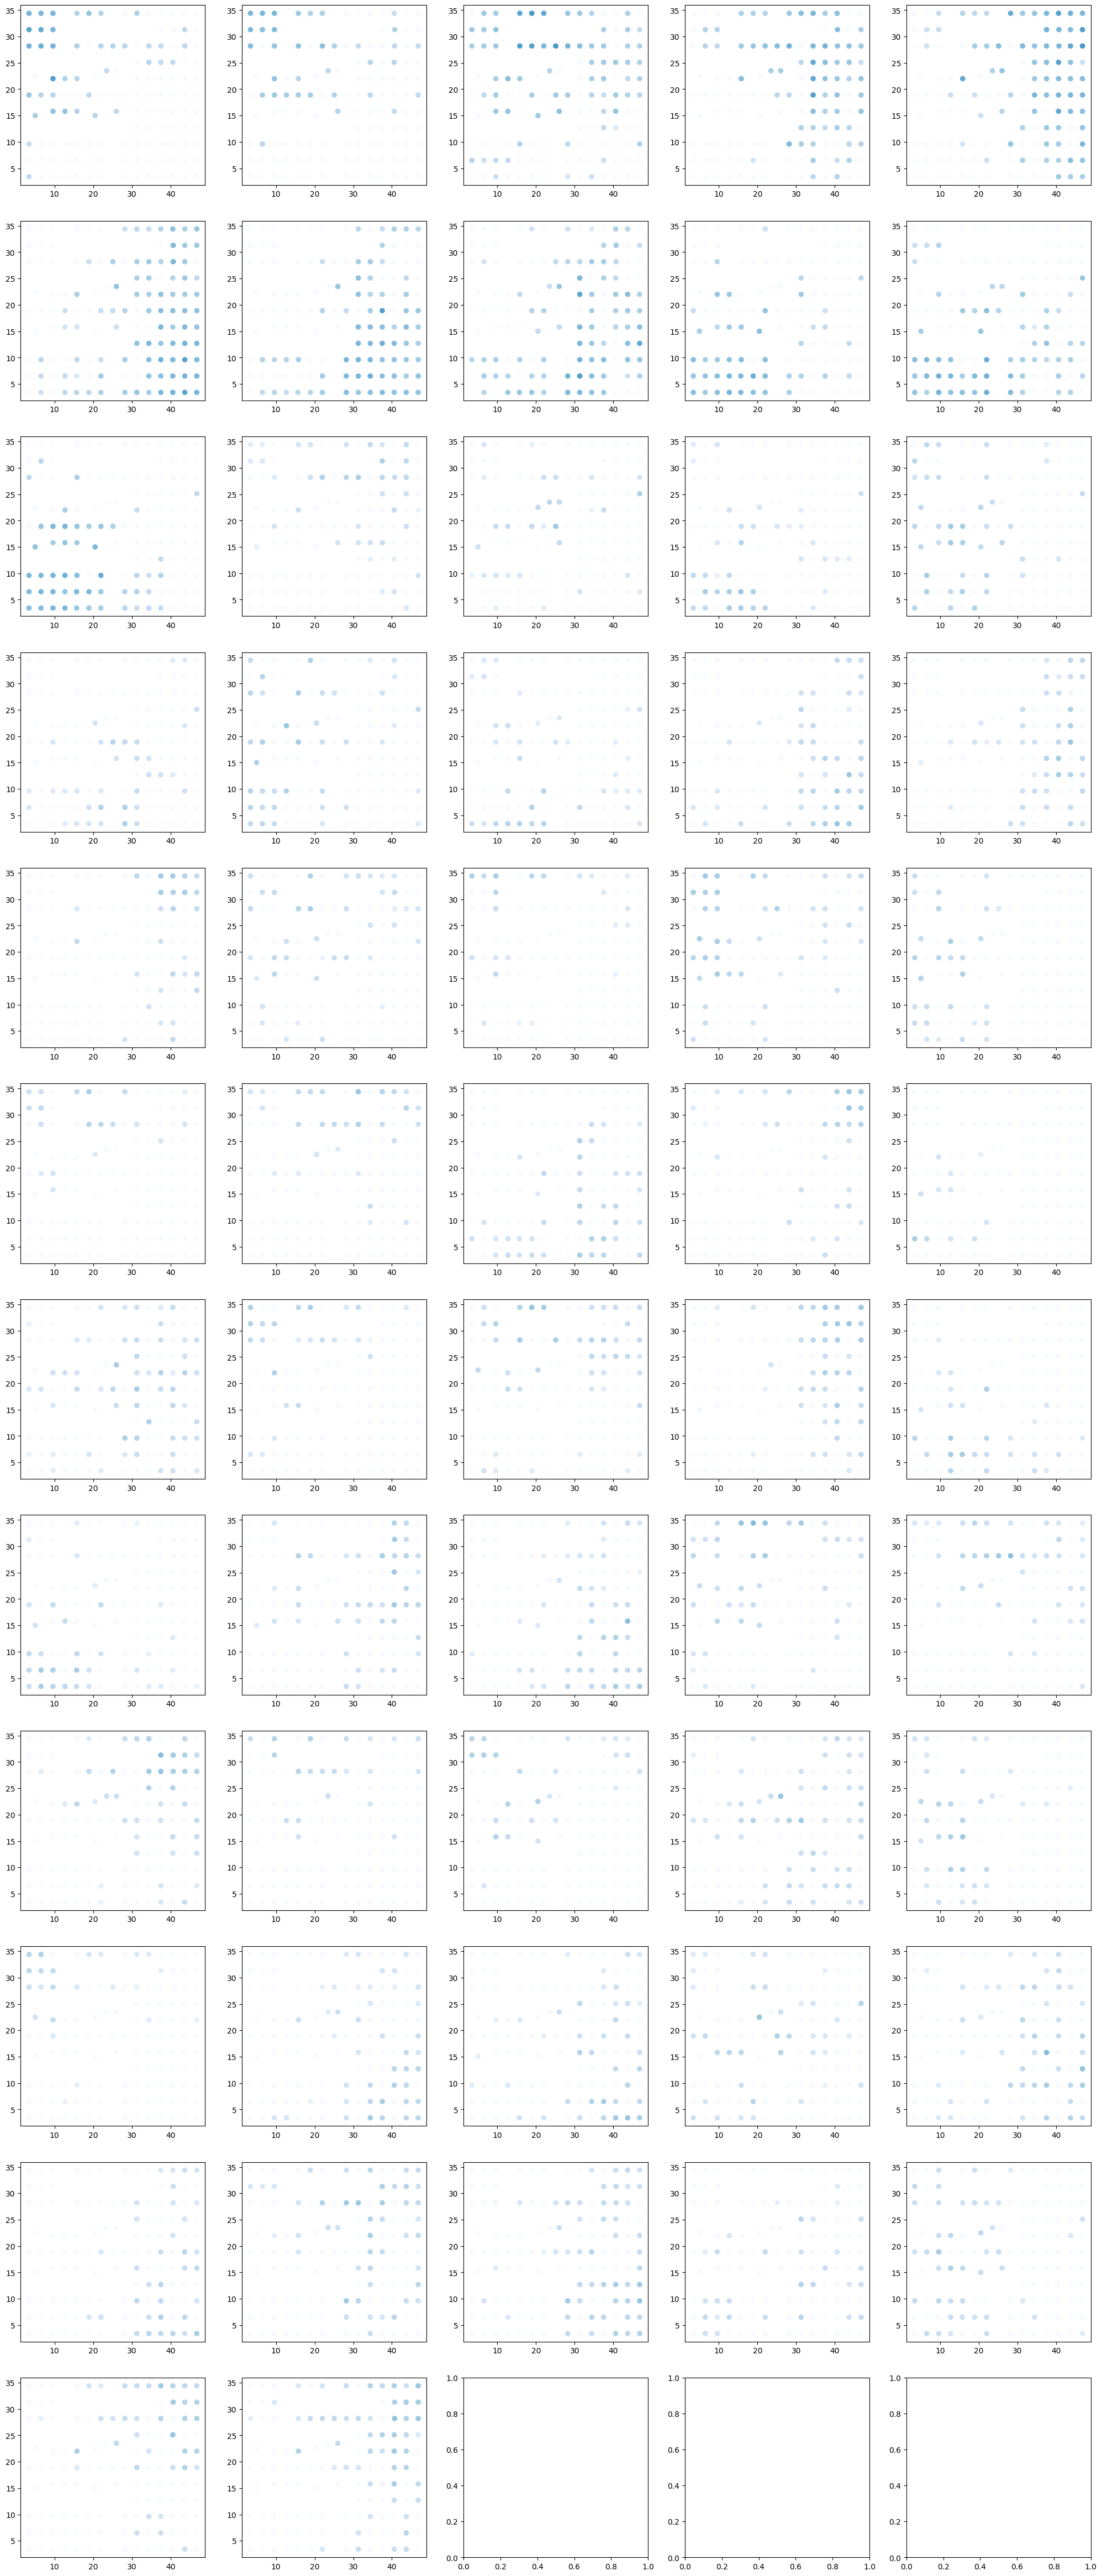

In [182]:
df_train_locs = pd.read_csv(DATASET_ROOT+TRAIN_LOCATIONS_FILE, sep=';', names=['x','y'], dtype=str)
df_train_locs = df_train_locs.apply(lambda x: [float(v.replace(',', '.')) for v in x])

df_test_locs = pd.read_csv(DATASET_ROOT+TEST_LOCATIONS_FILE, sep=';', names=['x','y'], dtype=str)
df_test_locs = df_test_locs.apply(lambda x: [float(v.replace(',', '.')) for v in x])

df_train_strengths = pd.read_csv(DATASET_ROOT+TRAIN_STRENGTHS_FILE, sep=';', names=[x for x in range(NUMBER_OF_BEACONS)])
df_test_strengths = pd.read_csv(DATASET_ROOT+TEST_STRENGTHS_FILE, sep=';', names=[x for x in range(NUMBER_OF_BEACONS)])

colors = [x for x in range(len(df_train_locs['x']))]

num_rows = math.ceil(NUMBER_OF_BEACONS / 5)
fig, axes = plt.subplots(num_rows, 5, figsize=(25, num_rows * 5))

s_min = -110.0
s_max = 0.0

for i in range(NUMBER_OF_BEACONS):
  axes[i // 5, i % 5].scatter(df_train_locs['x'], df_train_locs['y'], c=df_train_strengths[i], cmap='Blues', vmin=s_min, vmax=s_max)

In [183]:
train_features = df_train_strengths
train_target = df_train_locs

test_features = df_test_strengths
test_target = df_test_locs

normalization_values = np.array(train_features)

In [199]:
# Model definitions
normalizer = layers.Normalization()
normalizer.adapt(normalization_values)

def basic_model():
  model = tf.keras.models.Sequential([
      normalizer,
      layers.Dense(500, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(500, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(2, activation='relu'),
      layers.Dropout(0.5)
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  loss_function = tf.keras.losses.MeanSquaredError()

  model.compile(optimizer=optimizer,
                loss=loss_function)
  
  return model

In [200]:
model = basic_model()
print(model.summary())

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_25 (Normaliza  (None, 57)               115       
 tion)                                                           
                                                                 
 dense_78 (Dense)            (None, 500)               29000     
                                                                 
 dropout_78 (Dropout)        (None, 500)               0         
                                                                 
 dense_79 (Dense)            (None, 500)               250500    
                                                                 
 dropout_79 (Dropout)        (None, 500)               0         
                                                                 
 dense_80 (Dense)            (None, 2)                 1002      
                                                     

In [203]:
EPOCHS = 10000
BATCH_SIZE = 8

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=500)
history = model.fit(train_features, train_target, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es])

Epoch 1/10000
16/16 [==============================] - 0s 2ms/step - loss: 330.5562
Epoch 2/10000
16/16 [==============================] - 0s 1ms/step - loss: 316.4233
Epoch 3/10000
16/16 [==============================] - 0s 1ms/step - loss: 366.8238
Epoch 4/10000
16/16 [==============================] - 0s 1ms/step - loss: 331.5294
Epoch 5/10000
16/16 [==============================] - 0s 2ms/step - loss: 291.6204
Epoch 6/10000
16/16 [==============================] - 0s 1ms/step - loss: 362.8277
Epoch 7/10000
16/16 [==============================] - 0s 1ms/step - loss: 327.1024
Epoch 8/10000
16/16 [==============================] - 0s 2ms/step - loss: 307.6868
Epoch 9/10000
16/16 [==============================] - 0s 2ms/step - loss: 352.9997
Epoch 10/10000
16/16 [==============================] - 0s 1ms/step - loss: 334.9190
Epoch 11/10000
16/16 [==============================] - 0s 1ms/step - loss: 355.0949
Epoch 12/10000
16/16 [==============================] - 0s 2ms/step - loss

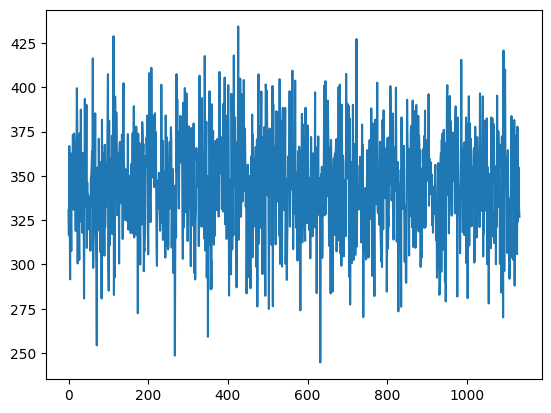

In [204]:
plt.plot(history.history['loss']);

In [205]:
model.evaluate(test_features, test_target)

15/15 [==============================] - 0s 927us/step - loss: 235.7309


235.73086547851562

In [206]:
predictions = model.predict(test_features)

for i in range(len(predictions)):
  print(predictions[i], np.array(test_target)[i])

15/15 [==============================] - 0s 829us/step
[22.090363  4.411563] [48.35  1.85]
[22.169012   3.7739995] [46.8   1.85]
[20.998499  4.1303  ] [45.25  1.85]
[23.195107   5.5850115] [43.7   1.85]
[19.58029    3.7286525] [42.15  1.85]
[20.076014   4.5568357] [40.6   1.85]
[20.790146   3.0889716] [39.05  1.85]
[20.44987    3.5138772] [37.5   1.85]
[18.294699   5.3110013] [35.95  1.85]
[18.503262   4.1988974] [34.4   1.85]
[18.923912   3.9708745] [32.85  1.85]
[17.517189   3.3263865] [31.3   1.85]
[19.669811  5.492218] [29.75  1.85]
[15.7376    4.592629] [28.2   1.85]
[13.636877  5.111527] [26.65  1.85]
[14.332706  3.765235] [26.65  3.4 ]
[19.349674   4.2716045] [29.75  3.4 ]
[17.157196   3.9524832] [32.85  3.4 ]
[16.905674   4.0633507] [35.95  3.4 ]
[17.50442    3.0833383] [39.05  3.4 ]
[21.94289    2.3045998] [42.15  3.4 ]
[23.23375   4.755805] [45.25  3.4 ]
[24.99959    4.4589257] [48.35  3.4 ]
[19.170908  5.409698] [48.35  4.95]
[17.238276  5.32734 ] [46.8   4.95]
[24.988104  4

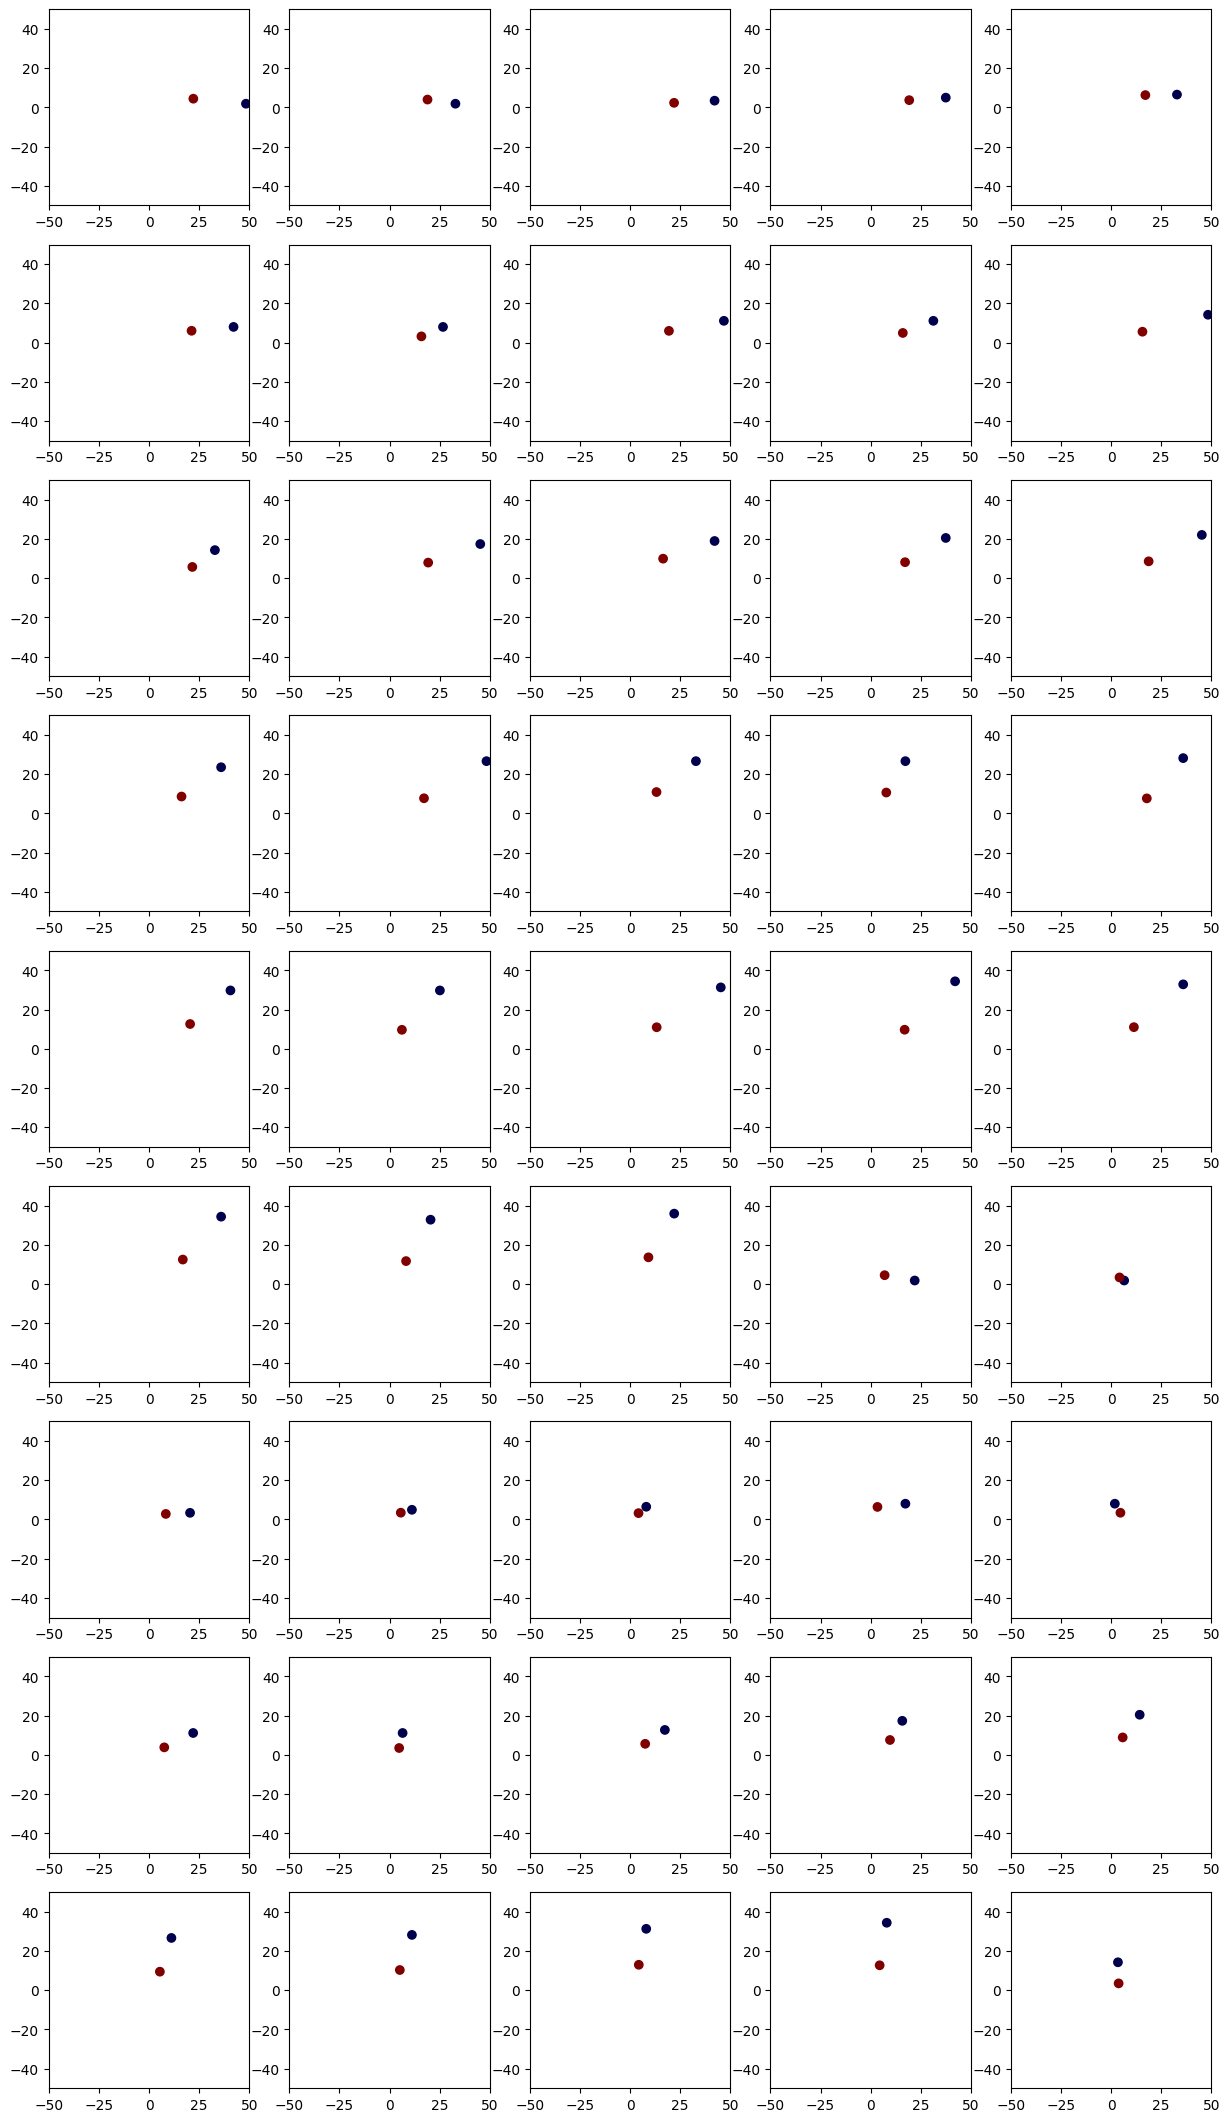

In [209]:
# Visualize predictions

SHOWN_PREDICTIONS = 45
X_MAX = 50
Y_MAX = 50

num_rows = math.ceil(SHOWN_PREDICTIONS / 5)
fig, axes = plt.subplots(num_rows, 5, figsize=(15, num_rows * 3))

for i in range(SHOWN_PREDICTIONS):
  p_index = (len(test_target) // SHOWN_PREDICTIONS) * i
  x = [test_target.iloc[p_index][0], predictions[p_index][0]]
  y = [test_target.iloc[p_index][1], predictions[p_index][1]]

  axes[i // 5, i % 5].scatter(x, y, c=[0, 1], cmap='seismic', vmin=0.0, vmax=1.0)
  axes[i // 5, i % 5].set_xlim(-X_MAX, X_MAX)
  axes[i // 5, i % 5].set_ylim(-Y_MAX, Y_MAX)
